In [41]:
%%bash
pip install dill

  Running setup.py install for dill: started
    Running setup.py install for dill: finished with status 'done'


In [27]:
import csv
import collections
import pandas
from sklearn import svm,metrics
from __future__ import division
import os
import numpy as np
import struct
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import mixture
from sklearn.preprocessing import MultiLabelBinarizer
from skimage import io; io.use_plugin('matplotlib')
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import csv
import os
import shutil
import imghdr
from sklearn.externals import joblib
import datetime
import time
import operator
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [24]:
csvfilepath='/opt/pgr/notebooks/complete_appgrimage.csv'
trainfilepath='/opt/pgr/resources/train.txt'
testfilepath='/opt/pgr/resources/test.txt'
featureVectorDir='/opt/pgr/featureVectors-4096'
imageDir="/opt/pgr/images/PGR"

In [3]:
%%bash
cd ..
cd resources
ls



bvlc_reference_caffenet.caffemodel
data.txt
deploy.prototxt
ilsvrc_2012_mean.npy
pgrLabels.csv
test.txt
test_specific.txt
train.txt
train_specific.txt


In [4]:
#Storing the filename and complaint type as list
with open(csvfilepath) as csvfile:
    csvReader=csv.reader(csvfile,delimiter=',')
    complainType=[]
    imageName=[]
    for row in csvReader:
        complainType.append(row[1])
        imageName.append(row[3])

In [5]:
count=collections.Counter(complainType)
print (count)

Counter({'Removal of Debris': 29630, 'Desilting of Drain': 21808, 'Removal of garbage': 9692, 'Non Burning of Street Lights': 6267, 'Stagnation of water': 4017, 'Absenteesim of sweepers': 3349, 'Disposal of removed silt on the Road': 2970, 'Unsanitary conditions on the road': 2939, 'Improper Sweeping': 2463, 'Burning of garbage': 2392, 'Absenteesim of door to door garbage collector': 2354, 'Broken Bin': 2240, 'Encroachment on the public property': 1892, 'Stray Pigs': 1653, 'Water pipe leakage': 1636, 'Bio Medical waste/Health hazard waste removal': 1452, 'Issues Related to Drinking Water Supply': 1356, 'Over flowing of garbage bins': 1354, 'Mosquito menace': 1343, 'Dog menace': 1247, 'Pot hole fill up/Repairs to the damage surface': 1230, 'Unauthorised / Illegal construction': 1220, 'Obstruction of water flow': 1195, 'Complaints related to property tax': 1115, 'Illegal draining of sewage to SWD/Open site': 1062, 'Issues relating to Vacant lands': 1043, 'Silt by the side of dividers': 9

In [119]:
#Creating dictionary of complaint type

groupDict={'Garbage':0,"Drain":1,"Pole":2,"Animals":3,"Building":4,"Road":5,"Trees":6,
            "Document":7,"Water":8,"Tap":9,"Shop":10}

groupclasslabels={}
i=0
with open('/opt/pgr/resources/pgrLabels.csv','r') as csvfile:
    csvReader=csv.reader(csvfile,delimiter=',')
    for row in csvReader:
        if row[0]=='label':
            continue
        groupclasslabels[row[0]]=groupDict[row[3]]
        i+=1
        if i==51:
            break

In [120]:
print groupclasslabels

{'Complaints related to property tax': 7, 'Stray Pigs': 3, 'Improper Sweeping': 0, 'Issues relating to Vacant lands': 4, 'Fevers - Dengue/Malaria/ Gastro-enteritis': 0, 'Unauthorised / Illegal construction': 4, 'Broken Bin': 0, 'Complaints regarding burial ground': 0, 'Obstruction of road by Trees branches': 6, 'Repairs to existing footpath': 5, 'Over flowing of garbage bins': 0, 'Illegal draining of sewage to SWD/Open site': 8, 'Open defecation- free (ODF)': 0, 'Death of Stray Animals': 3, 'Poor quality of work': 1, 'Complaints regarding Dispensary': 0, 'Unsanitary conditions on the road': 0, 'Removal of shops in the footpath': 10, 'Electric Shock due to street light': 2, 'Dog menace': 3, 'Bio Medical waste/Health hazard waste removal': 0, 'Issues Related to Drinking Water Supply': 8, 'Stagnation of water': 1, 'Desilting of Drain': 1, 'Community Toilets': 4, 'Absenteesim of sweepers': 0, 'Removal of Debris': 0, 'Repair Bore wells': 9, 'Complaints regarding public toilets': 4, 'Water p

In [123]:
#Generating txt file contaning files with specific labels
def createLabelSpecifictxt(src,txtfile,csvFilePath,dest,classlabels):
    List = open(txtfile).readlines()
    #print List
    data=[]
    
    for i in range(0,len(List)):
        data.append(List[i].strip('\n'))

    with open(dest,'w') as f:
        with open(csvFilePath) as csvfile:
            readCSV=csv.reader(csvfile,delimiter=',')
            labels=[]
            imageName=[]
            for row in readCSV:
                name=row[3]
                label=row[1]
                fullpath=os.path.join(src,name)
                if (os.path.isfile(fullpath) and (label in classlabels) and (name in data)):
                     f.write(name)
                     f.write('\n')

In [126]:
#Storing the extracted feature vectors in an matrix
def loadFeatureVectors(dirPath,txtfilepath, d):
    allFiles=[]
    n = sum(1 for line in open(txtfilepath))
    with open(txtfilepath) as fp:
        data = np.zeros([n, d])
        i=0
        for fileName in fp:
            fileName=fileName.strip('\n')
            allFiles.append(fileName)
            with open("%s/%s" % (dirPath, fileName), "rb") as inputFile:
                data[i] = struct.unpack('f'*d, inputFile.read())
                imageName.append(fileName)
                if(np.all(np.isfinite(data[i]))==False):
                    print i
                i+=1
    return (data, allFiles)

# Generating labels of the files with filename in given text file
def makelabels(csvfilepath,txtfilepath,classlabels):
    labels=[]
    with open(txtfilepath) as fp:
        df=pandas.read_csv(csvfilepath,error_bad_lines=False,header=None)
        df.columns = ["City", "Complaint Type", "Date", "FilestoreId","FilePath","Comments"]
        #print df
        imageNametoComplainType=dict(zip(df.FilestoreId, df['Complaint Type']))
        print len(imageNametoComplainType)
        for imageName in fp:
                 imageName=imageName.strip('\n')
                 labels.append(classlabels[imageNametoComplainType[imageName]])
        #print classlabels[data["Complaint Type"]] 
    return labels,imageNametoComplainType



In [127]:
data,imageNames=loadFeatureVectors(featureVectorDir,'/opt/pgr/resources/train_specific.txt',d=4096)
labels,imageNametoComplainType=makelabels(csvfilepath,'/opt/pgr/resources/train_specific.txt',groupclasslabels)

Skipping line 5915: expected 6 fields, saw 7
Skipping line 7098: expected 6 fields, saw 7
Skipping line 10597: expected 6 fields, saw 7
Skipping line 10698: expected 6 fields, saw 7
Skipping line 13905: expected 6 fields, saw 7
Skipping line 14054: expected 6 fields, saw 7
Skipping line 14966: expected 6 fields, saw 7
Skipping line 17086: expected 6 fields, saw 7
Skipping line 17778: expected 6 fields, saw 7
Skipping line 18459: expected 6 fields, saw 7
Skipping line 18481: expected 6 fields, saw 7
Skipping line 18507: expected 6 fields, saw 7
Skipping line 19552: expected 6 fields, saw 7
Skipping line 19553: expected 6 fields, saw 7
Skipping line 19554: expected 6 fields, saw 7
Skipping line 19555: expected 6 fields, saw 7
Skipping line 21552: expected 6 fields, saw 7
Skipping line 22104: expected 6 fields, saw 7
Skipping line 23608: expected 6 fields, saw 7
Skipping line 26617: expected 6 fields, saw 7
Skipping line 27292: expected 6 fields, saw 7
Skipping line 28324: expected 6 fiel

126186


In [128]:
print len(data),len(labels),len(imageNames)

97064 97064 97064


In [129]:
# Creating testing set labels and data
#createLabelSpecifictxt(featureVectorDir,testfilepath,csvfilepath,'/opt/pgr/resources/test_specific.txt')
dataTest,imageNamesTest=loadFeatureVectors(featureVectorDir,'/opt/pgr/resources/test_specific.txt',d=4096)
labelsTest,imageNametoComplainTypeTest=makelabels(csvfilepath,'/opt/pgr/resources/test_specific.txt',groupclasslabels)

Skipping line 5915: expected 6 fields, saw 7
Skipping line 7098: expected 6 fields, saw 7
Skipping line 10597: expected 6 fields, saw 7
Skipping line 10698: expected 6 fields, saw 7
Skipping line 13905: expected 6 fields, saw 7
Skipping line 14054: expected 6 fields, saw 7
Skipping line 14966: expected 6 fields, saw 7
Skipping line 17086: expected 6 fields, saw 7
Skipping line 17778: expected 6 fields, saw 7
Skipping line 18459: expected 6 fields, saw 7
Skipping line 18481: expected 6 fields, saw 7
Skipping line 18507: expected 6 fields, saw 7
Skipping line 19552: expected 6 fields, saw 7
Skipping line 19553: expected 6 fields, saw 7
Skipping line 19554: expected 6 fields, saw 7
Skipping line 19555: expected 6 fields, saw 7
Skipping line 21552: expected 6 fields, saw 7
Skipping line 22104: expected 6 fields, saw 7
Skipping line 23608: expected 6 fields, saw 7
Skipping line 26617: expected 6 fields, saw 7
Skipping line 27292: expected 6 fields, saw 7
Skipping line 28324: expected 6 fiel

126186


In [130]:
print len(dataTest),len(labelsTest),len(imageNamesTest)
print labelsTest[0:40]

24389 24389 24389
[5, 1, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [131]:
count=collections.Counter(labels)
print count
print len(data),len(labels)

Counter({0: 49648, 1: 22178, 2: 5887, 5: 4910, 8: 4780, 4: 4370, 3: 2964, 7: 873, 6: 679, 9: 400, 10: 375})
97064 97064


In [15]:
clf=joblib.load('gaussian_clustering_11.pkl') 

In [16]:
predict=clf.predict(data)

In [17]:
count=collections.Counter(predict)
print count

Counter({5: 13175, 9: 12912, 7: 10974, 10: 10699, 8: 10373, 3: 9094, 6: 8428, 0: 7766, 2: 6765, 4: 5101, 1: 1777})


In [18]:
print len(predict),len(imageNames)

97064 97064


In [ ]:
classDict=classlabels

for key in classDict.keys():
    classDict[key]=0

for i,filename in enumerate(imageNames):
    if predict[i]==4:
        value=imageNametoComplainType[filename]
        classDict[value]+=1
        
#print classDict
plt.bar(list(classDict.keys()), classDict.values(), color='b')
plt.show()    

sortedclassDict = sorted(classDict.items(), key=operator.itemgetter(1),reverse=True)

print sortedclassDict
      
        

In [20]:
def  cluster(className):
    clusterToclass=dict(enumerate(np.zeros(11)))
    for i,filename in enumerate(imageNames):
        value=imageNametoComplainType[filename]
        if value==className:
            clusterToclass[predict[i]]+=1
        
    plt.bar(list(clusterToclass.keys()), clusterToclass.values(), color='b')
    plt.show()    
    sortedclassDict = sorted(clusterToclass.items(), key=operator.itemgetter(1),reverse=True)
    print sortedclassDict

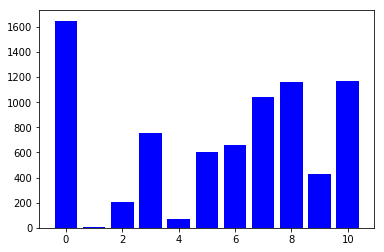

[(0, 1649.0), (10, 1171.0), (8, 1158.0), (7, 1040.0), (3, 755.0), (6, 663.0), (5, 605.0), (9, 431.0), (2, 202.0), (4, 74.0), (1, 7.0)]


In [22]:
cluster('Removal of garbage')

In [20]:
predict_proba=clf.predict_proba(data)

In [21]:
print predict_proba.shape

(97064, 11)


In [133]:
itr=0
for i in classlabels.keys():
    classlabels[i]=itr
    itr+=1
print classlabels

{'Complaints related to property tax': 0, 'Stray Pigs': 1, 'Improper Sweeping': 2, 'Issues relating to Vacant lands': 3, 'Fevers - Dengue/Malaria/ Gastro-enteritis': 4, 'Unauthorised / Illegal construction': 5, 'Broken Bin': 6, 'Complaints regarding burial ground': 7, 'Obstruction of road by Trees branches': 8, 'Repairs to existing footpath': 9, 'Over flowing of garbage bins': 10, 'Illegal draining of sewage to SWD/Open site': 11, 'Open defecation- free (ODF)': 12, 'Death of Stray Animals': 13, 'Poor quality of work': 14, 'Complaints regarding Dispensary': 15, 'Unsanitary conditions on the road': 16, 'Removal of shops in the footpath': 17, 'Electric Shock due to street light': 18, 'Dog menace': 19, 'Bio Medical waste/Health hazard waste removal': 20, 'Issues Related to Drinking Water Supply': 21, 'Stagnation of water': 22, 'Desilting of Drain': 23, 'Community Toilets': 24, 'Absenteesim of sweepers': 25, 'Removal of Debris': 26, 'Repair Bore wells': 27, 'Complaints regarding public toil

In [134]:
print len(classlabels)
labels,imageNametoComplainType=makelabels(csvfilepath,'/opt/pgr/resources/train_specific.txt',classlabels)

51


Skipping line 5915: expected 6 fields, saw 7
Skipping line 7098: expected 6 fields, saw 7
Skipping line 10597: expected 6 fields, saw 7
Skipping line 10698: expected 6 fields, saw 7
Skipping line 13905: expected 6 fields, saw 7
Skipping line 14054: expected 6 fields, saw 7
Skipping line 14966: expected 6 fields, saw 7
Skipping line 17086: expected 6 fields, saw 7
Skipping line 17778: expected 6 fields, saw 7
Skipping line 18459: expected 6 fields, saw 7
Skipping line 18481: expected 6 fields, saw 7
Skipping line 18507: expected 6 fields, saw 7
Skipping line 19552: expected 6 fields, saw 7
Skipping line 19553: expected 6 fields, saw 7
Skipping line 19554: expected 6 fields, saw 7
Skipping line 19555: expected 6 fields, saw 7
Skipping line 21552: expected 6 fields, saw 7
Skipping line 22104: expected 6 fields, saw 7
Skipping line 23608: expected 6 fields, saw 7
Skipping line 26617: expected 6 fields, saw 7
Skipping line 27292: expected 6 fields, saw 7
Skipping line 28324: expected 6 fiel

126186


In [135]:
print labels

[20, 32, 18, 23, 23, 23, 11, 23, 11, 11, 33, 34, 40, 40, 40, 6, 37, 28, 26, 26, 27, 6, 25, 32, 40, 32, 32, 32, 44, 44, 44, 44, 44, 44, 16, 16, 39, 39, 32, 3, 32, 32, 32, 40, 16, 20, 3, 32, 40, 40, 16, 40, 40, 40, 40, 40, 44, 40, 16, 40, 40, 40, 40, 40, 40, 32, 10, 32, 32, 10, 32, 10, 40, 40, 13, 10, 32, 40, 32, 10, 32, 28, 32, 32, 32, 10, 32, 32, 10, 32, 28, 31, 23, 23, 40, 40, 23, 40, 40, 31, 28, 32, 32, 32, 40, 40, 32, 10, 10, 40, 32, 40, 40, 40, 40, 32, 10, 10, 40, 32, 32, 32, 32, 32, 25, 25, 32, 32, 32, 32, 25, 25, 32, 32, 32, 25, 32, 32, 32, 32, 32, 23, 10, 32, 32, 40, 10, 10, 10, 10, 32, 26, 27, 40, 40, 10, 10, 32, 40, 10, 10, 10, 10, 40, 10, 40, 10, 10, 32, 32, 32, 32, 32, 23, 23, 23, 32, 32, 32, 10, 10, 10, 40, 10, 40, 40, 40, 40, 40, 10, 10, 10, 10, 10, 32, 10, 20, 40, 40, 40, 32, 32, 32, 32, 32, 32, 10, 26, 32, 10, 40, 10, 10, 10, 40, 40, 10, 10, 10, 10, 10, 32, 23, 10, 40, 32, 25, 25, 32, 32, 22, 40, 40, 23, 40, 32, 10, 10, 32, 10, 10, 10, 10, 10, 32, 23, 32, 40, 10, 10, 10,

In [25]:
clf2=joblib.load('proba_svm.pkl') 

In [136]:
labelsTest,imageNametoComplainTypeTest=makelabels(csvfilepath,'/opt/pgr/resources/test_specific.txt',classlabels)


Skipping line 5915: expected 6 fields, saw 7
Skipping line 7098: expected 6 fields, saw 7
Skipping line 10597: expected 6 fields, saw 7
Skipping line 10698: expected 6 fields, saw 7
Skipping line 13905: expected 6 fields, saw 7
Skipping line 14054: expected 6 fields, saw 7
Skipping line 14966: expected 6 fields, saw 7
Skipping line 17086: expected 6 fields, saw 7
Skipping line 17778: expected 6 fields, saw 7
Skipping line 18459: expected 6 fields, saw 7
Skipping line 18481: expected 6 fields, saw 7
Skipping line 18507: expected 6 fields, saw 7
Skipping line 19552: expected 6 fields, saw 7
Skipping line 19553: expected 6 fields, saw 7
Skipping line 19554: expected 6 fields, saw 7
Skipping line 19555: expected 6 fields, saw 7
Skipping line 21552: expected 6 fields, saw 7
Skipping line 22104: expected 6 fields, saw 7
Skipping line 23608: expected 6 fields, saw 7
Skipping line 26617: expected 6 fields, saw 7
Skipping line 27292: expected 6 fields, saw 7
Skipping line 28324: expected 6 fiel

126186


In [137]:
print data.shape,dataTest.shape
predicted_proba_Test=clf.predict_proba(dataTest)

(97064, 4096) (24389, 4096)


In [28]:
predicted_proba_Test_2=clf2.predict_proba(predicted_proba_Test)

In [29]:
print predicted_proba_Test_2.shape
print type(predicted_proba_Test_2)

(24389, 51)
<type 'numpy.ndarray'>


In [30]:
count=0
for i in range(0,predicted_proba_Test_2.shape[0]):
    classdataDict=dict(enumerate(predicted_proba_Test_2[i,:]))
    #rint type(classdataDict)
    classdataDict = sorted(classdataDict.items(), key=operator.itemgetter(1),reverse=True)
    #rint type(classdataDict)
    keys=dict(classdataDict).keys()
    predictedClasses=keys[:10]
    if labelsTest[i] in predictedClasses:
        count+=1
    
print count
    

2351


In [33]:
c=collections.Counter(labelsTest)
print c

Counter({26: 5816, 23: 4322, 32: 1921, 49: 1259, 22: 815, 25: 673, 50: 628, 16: 589, 2: 533, 39: 503, 46: 487, 6: 443, 36: 378, 29: 344, 1: 313, 20: 309, 31: 295, 10: 273, 21: 273, 19: 251, 33: 246, 37: 244, 11: 233, 5: 229, 0: 213, 3: 197, 45: 196, 41: 176, 40: 171, 42: 158, 12: 141, 14: 132, 28: 120, 4: 117, 9: 116, 47: 113, 38: 110, 17: 103, 27: 102, 7: 96, 13: 96, 8: 94, 43: 83, 44: 72, 30: 70, 34: 62, 35: 62, 18: 61, 48: 55, 15: 54, 24: 42})


In [48]:
print labelsTest[0]
print classlabels
print predicted_proba_Test[0]

33
{'Complaints related to property tax': 0, 'Stray Pigs': 1, 'Improper Sweeping': 2, 'Issues relating to Vacant lands': 3, 'Fevers - Dengue/Malaria/ Gastro-enteritis': 4, 'Unauthorised / Illegal construction': 5, 'Broken Bin': 6, 'Complaints regarding burial ground': 7, 'Obstruction of road by Trees branches': 8, 'Repairs to existing footpath': 9, 'Over flowing of garbage bins': 10, 'Illegal draining of sewage to SWD/Open site': 11, 'Open defecation- free (ODF)': 12, 'Death of Stray Animals': 13, 'Poor quality of work': 14, 'Complaints regarding Dispensary': 15, 'Unsanitary conditions on the road': 16, 'Removal of shops in the footpath': 17, 'Electric Shock due to street light': 18, 'Dog menace': 19, 'Bio Medical waste/Health hazard waste removal': 20, 'Issues Related to Drinking Water Supply': 21, 'Stagnation of water': 22, 'Desilting of Drain': 23, 'Community Toilets': 24, 'Absenteesim of sweepers': 25, 'Removal of Debris': 26, 'Repair Bore wells': 27, 'Complaints regarding public t

# Clusterwise Analysis

In [108]:
def imagesInSpecificCluster(clusternumber):
    c=[]
    for i in range(0,len(predict)):
        if predict[i]==clusternumber:
            c.append(imageNames[i])
    return c       

#Storing the extracted feature vectors in an matrix
def loadFeatureVectors2(featureVectorDir,imageNamesList, d):
    allFiles=[]
    n = len(imageNamesList)
    print n
    data = np.zeros([n, d])
    i=0
    for fileName in imageNamesList:
        fileName=fileName.strip('\n')
        allFiles.append(fileName)
        with open("%s/%s" % (featureVectorDir, fileName), "rb") as inputFile:
            data[i] = struct.unpack('f'*d, inputFile.read())
            imageName.append(fileName)
            if(np.all(np.isfinite(data[i]))==False):
                print i
            i+=1
    return (data)

In [78]:
c0=imagesInSpecificCluster(0)
dataCluster0=loadFeatureVectors2(featureVectorDir,c0,d=4096)

7766


In [79]:
print data.shape
print dataCluster0.shape

(97064, 4096)
(7766, 4096)


In [80]:
print "Start: ",time.clock()
clfCluster0 = mixture.GaussianMixture(n_components=5,  covariance_type='full')
clfCluster0.fit(dataCluster0)
print "End: ",time.clock()

Start:  8008.361392
End:  8728.147321


In [85]:
predictedCluster0=clfCluster0.predict(dataCluster0)

In [86]:
count=collections.Counter(predictedCluster0)
print count

Counter({3: 2259, 4: 1592, 1: 1357, 0: 1294, 2: 1264})


In [90]:
def showImages(predict,clusternumber,imageNames):
    displayImages=[]
    for i in range(0,len(predict)):
        if predict[i]==clusternumber:
                value=imageNames[i]
            fullpath=os.path.join(imageDir,value)
            displayImages.append(fullpath)

    l=displayImages[0:500]
    for fullpath in l:
        if os.path.isfile(fullpath):
            img=mpimg.imread(fullpath)
            imgplot = plt.imshow(img)
            plt.show()
                

In [ ]:
showImages(predictedCluster0,4,c0)

In [99]:
 dataCluster0_embedded = TSNE(n_components=2).fit_transform(dataCluster0)

In [100]:
dataCluster0_embedded.shape

(7766, 2)

In [101]:
print dataCluster0_embedded

[[ 48.64632   -30.542465 ]
 [-22.927116  -41.298065 ]
 [ 11.723634  -14.096579 ]
 ...
 [ 35.304787    8.99431  ]
 [-33.47568   -40.076706 ]
 [ -5.7041802   8.623309 ]]


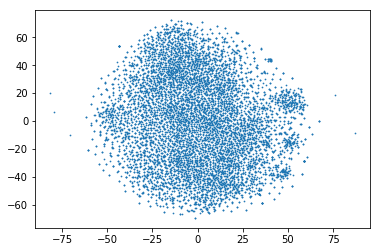

In [107]:
X=dataCluster0_embedded[:,0]
Y=dataCluster0_embedded[:,1]
plt.scatter(X,Y,s=0.5)

In [ ]:
c5=imagesInSpecificCluster(5)
dataCluster5=loadFeatureVectors2(featureVectorDir,c5,d=4096)
dataCluster5_embedded = TSNE(n_components=2).fit_transform(dataCluster5)

In [ ]:
X=dataCluster5_embedded[:,0]
Y=dataCluster5_embedded[:,1]
plt.scatter(X,Y,s=0.5)

# Top two classes

In [112]:
# Store feature vectors with specific labels in matrix
def loadFeatureVectorsByClass(dirPath,txtfilepath,classes,labels, d):
    n = sum(1 for line in open(txtfilepath))
    count=collections.Counter(labels)
    l=0
    for i in classes:
        l+=count[i]
    data = np.zeros([l, d])
    labelsInTwoClass=[]
    imageName=[]
    with open(txtfilepath) as fp:
        itr=0
        for i, fileName in enumerate(fp):
            if labels[i] in classes:
                fileName=fileName.strip('\n')
                with open("%s/%s" % (dirPath, fileName), "rb") as inputFile:
                        data[itr] = struct.unpack('f'*d, inputFile.read())
                        itr+=1
                        labelsInTwoClass.append(labels[i])
                        imageName.append(fileName)
    return (data, labelsInTwoClass,imageName)

In [116]:
print labels

[109, 1649, 0, 1286, 1286, 1286, 32, 1286, 32, 32, 27, 3, 114, 114, 114, 605, 18, 22, 358, 358, 5, 605, 443, 1649, 114, 1649, 1649, 1649, 21, 21, 21, 21, 21, 21, 369, 369, 362, 362, 1649, 49, 1649, 1649, 1649, 114, 369, 109, 49, 1649, 114, 114, 369, 114, 114, 114, 114, 114, 21, 114, 369, 114, 114, 114, 114, 114, 114, 1649, 269, 1649, 1649, 269, 1649, 269, 114, 114, 30, 269, 1649, 114, 1649, 269, 1649, 22, 1649, 1649, 1649, 269, 1649, 1649, 269, 1649, 22, 38, 1286, 1286, 114, 114, 1286, 114, 114, 38, 22, 1649, 1649, 1649, 114, 114, 1649, 269, 269, 114, 1649, 114, 114, 114, 114, 1649, 269, 269, 114, 1649, 1649, 1649, 1649, 1649, 443, 443, 1649, 1649, 1649, 1649, 443, 443, 1649, 1649, 1649, 443, 1649, 1649, 1649, 1649, 1649, 1286, 269, 1649, 1649, 114, 269, 269, 269, 269, 1649, 358, 5, 114, 114, 269, 269, 1649, 114, 269, 269, 269, 269, 114, 269, 114, 269, 269, 1649, 1649, 1649, 1649, 1649, 1286, 1286, 1286, 1649, 1649, 1649, 269, 269, 269, 114, 269, 114, 114, 114, 114, 114, 269, 269, 269,

In [140]:
dataTop2Cluster,labelsTop2Cluster,imageName=loadFeatureVectorsByClass(featureVectorDir,'/opt/pgr/resources/train_specific.txt',[23,26],labels,d=4096)

In [141]:
print len(dataTop2Cluster)

41131


In [ ]:
dataTop2Cluster_embedded = TSNE(n_components=2).fit_transform(dataTop2Cluster)

In [ ]:
X=dataTop2Cluster_embedded[:,0]
Y=dataTop2Cluster_embedded[:,1]
plt.scatter(X,Y,s=0.5)